In [20]:
# first, let's import some packages that we need

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<div class="alert alert-success" role="alert">
<h2> Assignment 1: The impact of context (40 points) </h2><br>
Besides the bandits encountered above, we can construct a wide variety of different versions.
    
For example, the type of reward distribution can be varied. We have already encountered _binomial rewards_ in the <code>draw_from_k_bandits</code>. For this bandit, reward distributions indicated the reward probablity associated with each action. We have also already encountered _Gaussian rewards_ in the <code>draw_from_k_gaussian_bandits</code>. Contrary to the binomial rewards, determinstic rewards do not include binomial noise, but Gaussian noise.  

Moreover, we can make a distinction between _stationary (stable)_ and _walking (volatile)_ reward distributions. So far, we have only encountered fixed rewards distributions. Rewards were always drawn from a stable environment and did not change over time. We simulated a walking bandit by generating multiple different walks and glueing them together (flattening). 

For truely walking rewards distributions, noise is added to the defining parameters of the distribution. For example, on every new trial of our <code>draw_from_k_bandits</code>, the new reward probablity could be set to the old rewards probability plus some normal noise with mean 0 and standard deviation 0.05. Please note, that this makes it necessary to define bounds, as rewards probabilities (e.g., binomial) need to be set between 0 and 1. Gaussian rewards should not wander off too much but rather stay between 0 and 100.


> Set up the 4 possible bandits with the following properties (20 points) <br>
> 1. Binomial rewards with fixed reward probabilities (as implemented already in <code>generate_uniform_bandit</code>)
> 2. Binomial rewards with walking reward probabilities
> 3. Gaussian rewards with fixed mean rewards (bound between 0 and 1)
> 4. Gaussian rewards with walking mean rewards (bound between 0 and 1)

> Visualize the bandits. For visualization, use one-armed variants. Plot their true reward probabilites, obtained rewards, etc. (10 points)

> Plot how the performance of our weighted average, softmax RL agents differs between these bandits. For this excersise, use two-armed bandits. For the agent, fix the learning rate (alpha) to 0.1 and the softmax inverse temperature (beta) to 2. (10 points)

</div>

In [21]:
#Assignment 1, part A


def binominal(n_trials, prob):  
    reward_samples = np.random.binomial(1,prob,n_trials)
    probabilities = np.full(n_trials, prob)
    return reward_samples, probabilities

def binominal_walking(n_trials, prob, noise=0.05):
    noisy_prob=[prob] 
    for i in range(n_trials-1):
        new_prob = np.clip(noisy_prob[-1]+float(np.random.normal(size=1, loc=0, scale=noise)), 0,1)
        noisy_prob.append(new_prob)
    reward_samples = np.random.binomial(1, noisy_prob, n_trials)  
    return reward_samples, noisy_prob

def gaussian(n_trials, mean_reward):  
    reward_samples = np.random.normal(size=n_trials, loc=mean_reward, scale=1)   
    means = np.full(n_trials, mean_reward)
    return reward_samples, means

def gaussian_walking(n_trials, mean_reward, noise = 0.05): 
    noisy_means=[mean_reward] 
    for i in range(n_trials-1):
        noisy_means.append(noisy_means[-1]+float(np.random.normal(size=1, loc=0, scale=noise)))
    reward_samples = np.random.normal(size=n_trials, loc=noisy_means, scale=1)  # Generate samples directly
    return reward_samples, noisy_means



def draw_from_k_bandits(n_trials, parameter, bandit, noise=0.05):
    
    n_bandits = len(parameter)  # how many arms?
    reward_samples = np.empty((n_bandits, n_trials))
    reward_probs = np.empty((n_bandits, n_trials))
    for i, parameter in enumerate(parameter):
        if bandit is gaussian_walking:
            reward_samples[i,:], reward_probs[i,:] = bandit(n_trials, parameter, noise)  
        else:
            reward_samples[i,:], reward_probs[i,:] = bandit(n_trials, parameter)
    return reward_samples, reward_probs





# print('true value: %f' % np.mean(reward_probs))
# print('average value of samples: %f' % np.mean(reward_samples))
# print('estimate of value after 1000 samples: %f' % mean_avg[0,-1])

# print(reward_probs)



In [22]:
def calculate_means_average(n_trials, parameters, agent):
    reward_samples, reward_parameters = draw_from_k_bandits(n_trials, parameters, agent)
    mean_avg = np.empty((1,n_trials+1))  
    for iT in np.arange(n_trials):
        if iT == 0:
            mean_avg[0,0] = 0.5     
        mean_avg[0,iT+1] = mean_avg[0,iT] + (1/(iT+1))*(reward_samples[0,iT]-mean_avg[0,iT])
    return mean_avg, reward_parameters

def calculate_means_weighted_average(n_trials, parameters, agent, alpha=0.1):
    reward_samples, reward_parameters = draw_from_k_bandits(n_trials, parameters, agent)
    mean_avg = np.empty((1,n_trials+1))  
    for iT in np.arange(n_trials):
        if iT == 0:
            mean_avg[0,0] = 0.5     
        mean_avg[0,iT+1] = mean_avg[0,iT] + alpha*(reward_samples[0,iT]-mean_avg[0,iT])
    return mean_avg, reward_parameters

In [23]:
n_trials = 1000
prob = [0.7]
means = [50]

In [24]:
#Part B
mean_avg_b, reward_probs_b = calculate_means_average(n_trials, prob, binominal)
mean_avg_bw, reward_probs_bw = calculate_means_average(n_trials, prob, binominal_walking)
mean_avg_g, reward_mean_g = calculate_means_average(n_trials, means, gaussian)
mean_avg_gw, reward_mean_gw = calculate_means_average(n_trials, means, gaussian_walking)


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
axs[0, 0].plot(np.arange(n_trials),reward_probs_b[0,:],'-k',label = 'true mean')
axs[0, 0].plot(np.arange(n_trials),mean_avg_b[0,1:],'-b',label ='average method')  
axs[0, 0].set_xlabel('trial')
axs[0, 0].set_ylabel('estimated reward')
axs[0, 0].set_title('Binominal stable')

axs[0, 1].plot(np.arange(n_trials),reward_probs_bw[0,:],'-k',label = 'true mean')
axs[0, 1].plot(np.arange(n_trials),mean_avg_bw[0,1:],'-b',label ='average method') 
axs[0, 1].set_xlabel('trial')
axs[0, 1].set_ylabel('estimated reward') 
axs[0, 1].set_title('Binominal walking agent')

axs[1, 0].plot(np.arange(n_trials),reward_mean_g[0,:],'-k',label = 'true mean')
axs[1, 0].plot(np.arange(n_trials),mean_avg_g[0,1:],'-b',label ='average method') 
axs[1, 0].set_xlabel('trial')
axs[1, 0].set_ylabel('estimated reward')
axs[1, 0].set_title('Gaussian stable')

axs[1, 1].plot(np.arange(n_trials),reward_mean_gw[0,:],'-k',label = 'true mean')
axs[1, 1].plot(np.arange(n_trials),mean_avg_gw[0,1:],'-b',label ='average method') 
axs[1, 1].set_xlabel('trial')
axs[1, 1].set_ylabel('estimated reward')
axs[1, 1].set_title('Gaussian walking bandit')


fig.text(0.5, 0.91, 'Binominal bandits', ha='center', fontsize=14)  # Top row title
fig.text(0.5, 0.48, 'Gaussian bandits', ha='center', fontsize=14)

C:\Users\Lena\AppData\Local\Temp\ipykernel_2576\3413872534.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_prob = np.clip(noisy_prob[-1]+float(np.random.normal(size=1, loc=0, scale=noise)), 0,1)
C:\Users\Lena\AppData\Local\Temp\ipykernel_2576\3413872534.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noisy_means.append(noisy_means[-1]+float(np.random.normal(size=1, loc=0, scale=noise)))


Text(0.5, 0.48, 'Gaussian bandits')

Error in callback <function flush_figures at 0x0000027E0200FBA0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [4]:
#Part 3 

def action_softm(values, beta):

    nOptions = len(values)  # Ensure nOptions matches the number of values
    actions = np.arange(nOptions)  # Create actions array with same length as values
    prob = np.exp(beta * values) / np.sum(np.exp(beta * values))
    action = np.random.choice(actions, size=1, p=prob)  # Choose action based on probabilities
    return int(action)

In [5]:
def run_experiment(parameters, agent, beta=2, n_agents=1000, n_trials=1000, learning_rate=0.1, volatility=0.05):

    rewards_softmax = np.empty((n_agents,n_trials))
    optimum_softmax = np.empty((n_agents,n_trials))
    for iA in np.arange(n_agents): 
        if agent is gaussian_walking:
            reward_samples, reward_param = draw_from_k_bandits(n_trials, parameters, agent, volatility)
        else:
            reward_samples, reward_param = draw_from_k_bandits(n_trials, parameters, agent)
        #initialize the estimated values for each bandit
        values = np.zeros(2)
        
        for iT in np.arange(n_trials):    
            optimal_action = np.argmax([reward_param[0, iT], reward_param[1, iT]])
            #chose action
            action = action_softm(values, beta)
        
            #calculate prediction error
            PE = reward_samples[action][iT]-values[action]
            #update value
            values[action] = values[action] + (learning_rate)*PE
            
            #store reward
            rewards_softmax[iA,iT] = reward_samples[action,iT]
            if action == optimal_action:
                optimum_softmax[iA,iT] = 1
            else:
                optimum_softmax[iA,iT] = 0

    return rewards_softmax, optimum_softmax



In [132]:
rewards_b, optimum_b = run_experiment( [0.2, 0.8], binominal)
rewards_bw, optimum_bw = run_experiment( [0.2, 0.8], binominal_walking)
rewards_gw, optimum_g = run_experiment( [0.2, 0.8], gaussian)
rewards_g, optimum_gw = run_experiment( [0.2, 0.8], gaussian_walking)

C:\Users\Lena\AppData\Local\Temp\ipykernel_5564\3828766243.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)


KeyboardInterrupt: 

NameError: name 'n_trials' is not defined

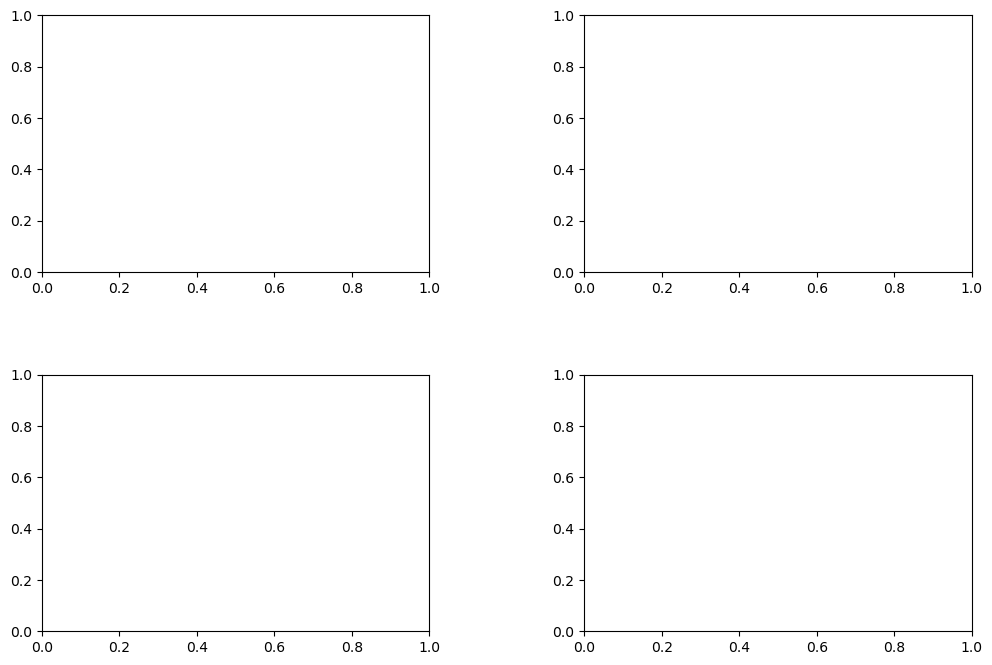

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)


axs[0, 0].plot(np.arange(n_trials),np.mean(rewards_bw,0),'-b',label='Binominal walking')
axs[0, 0].plot(np.arange(n_trials),np.mean(rewards_b,0),'-r',label='Binominal stable')
axs[0, 0].legend(loc="lower right") 
axs[0, 0].set_xlabel('trial')
axs[0, 0].set_ylabel('average reward')


axs[0, 1].plot(np.arange(n_trials),np.mean(optimum_b,0),'-r',label='Binominal stable')
axs[0, 1].plot(np.arange(n_trials),np.mean(optimum_bw,0),'-b',label='Binominal walking')
axs[0, 1].legend(loc="lower right")    
axs[0, 1].set_xlabel('trial')
axs[0, 1].set_ylabel('% optimal choice')


axs[1, 0].plot(np.arange(n_trials),np.mean(rewards_g,0),'-y',label='Gaussian stable')
axs[1, 0].plot(np.arange(n_trials),np.mean(rewards_gw,0),'-g',label='Gaussian walking')
axs[1, 0].legend(loc="lower right") 
axs[1, 0].set_xlabel('trial')
axs[1, 0].set_ylabel('average reward')


axs[1, 1].plot(np.arange(n_trials),np.mean(optimum_g,0),'-y',label='Gaussian stable')
axs[1, 1].plot(np.arange(n_trials),np.mean(optimum_gw,0),'-g',label='Gaussian walking')
axs[1, 1].legend(loc="lower right") 
axs[1, 1].set_xlabel('trial')
axs[1, 1].set_ylabel('% optimal choice')

fig.text(0.5, 0.91, 'Binominal bandits', ha='center', fontsize=14)  # Top row title
fig.text(0.5, 0.48, 'Gaussian bandits', ha='center', fontsize=14) 


<div class="alert alert-success" role="alert">
<h2> Assignment 2: The interaction of agent and context (30 points) </h2><br>

Environmental change is a crucial aspect that any learning agents has to take into account. We have already seen, how different learning rules (average vs. weighted-average) can be (mal)adaptive, dependent on the environment. Now, we are going to have a closer look into this issue and investigate how the speed of environmental change influences performance of our bandit.     

> Set up a bandit with Gaussian rewards and walking reward probabilities (see bandit option 4 in assignment 1) and add an additional parameter for volatility (i.e., the standard deviation of the normal distribution that governs the _walk_)
    
> Before coding, come up with hypotheses. Would you want your learning rate (alpha) to be high or low in a rapidly changing environment? Would you want your inverse temperature (beta) to be higher or lower in rapidly changing environments? (15 points)
    
> Show how the parameters of our agent is traded-off with different speeds of environmental volatility. Could you verify your intuitions as stated in the hypotheses? (15 points)

    
</div>

<div class="alert alert-success" role="alert">
<h2> Assignment 3: Alternatives to performance (30 points) </h2><br>

So far, we have encountered two measures of performance: 
- Overall or average reward collected by the agent
- proportion of optimal (=greedy) choices
    
There is a another way to look at performance: How well do our expectations of the environment match with the true value of the environment? Put differently, how well do our Q-values track the reward probabilities that generate rewards? The idea is simple: The better our estimate about the true values, the better our decision making will be.
    
> Plot the Q values together with the reward probabilities and compare the performance of the same RL agents for binomial and Gaussian rewards in a walking/changing environment. (15 points)     

A simple metric that you could utilize to quantify performance is the correlation coefficient. High correlation means that Qvalues and true probabilities are aligned, with r=1 indicating a perfect match. Low correlation means that Qvalues and true probabilities are not aligned, with r=0 indicating no connection at all.

> Compare the performance of different agents. Can you manually fine-tune the agent's parameters to optimize correlation?  (15 points)


(Please note that averaging correlation coefficients, e.g. between blocks or agents, is a bit tricky. Use Fisher's z  transformation (<code>numpy.arctanh</code>), average, and then transform back (<code>numpy.tanh</code>), to obtain meaningful results. Alternatively you could also estimate one correlation coefficient for ALL data at once.)

 
</div>

[fisher's z](https://en.wikipedia.org/wiki/Fisher_transformation)<br>



In [62]:
def run_experiment_compare(parameters, agent, beta=2, n_agents=1000, n_trials=1000, learning_rate=0.1, volatility=0.05, policy=action_softm):
    n_bandits = len(parameters)
    all_reward_probs = np.empty((n_agents, n_trials)) 
    all_bandit_values = np.empty((n_agents, n_trials)) 
    for iA in np.arange(n_agents): 
        if agent is gaussian_walking:
            reward_samples, reward_param = draw_from_k_bandits(n_trials, parameters, agent, volatility)
        else:
            reward_samples, reward_param = draw_from_k_bandits(n_trials, parameters, agent)

        # keep track of the reward probabilities (for all trials)
        all_reward_probs[iA] = reward_param

        #initialize the estimated values for each bandit
        values = np.zeros(n_bandits)
        
        for iT in np.arange(n_trials):    
            #chose action
            action = policy(values, beta)
        
            #calculate prediction error
            PE = reward_samples[action][iT]-values[action]
            #update value
            values[action] = values[action] + (learning_rate)*PE

            #only works for 1 bandit
            all_bandit_values[iA][iT] = values[0]
            

    return all_bandit_values, all_reward_probs  

    


C:\Users\Lena\AppData\Local\Temp\ipykernel_2576\3413872534.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noisy_means.append(noisy_means[-1]+float(np.random.normal(size=1, loc=0, scale=noise)))
C:\Users\Lena\AppData\Local\Temp\ipykernel_2576\3828766243.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)
C:\Users\Lena\AppData\Local\Temp\ipykernel_2576\3413872534.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_prob = np.clip(noisy_pr

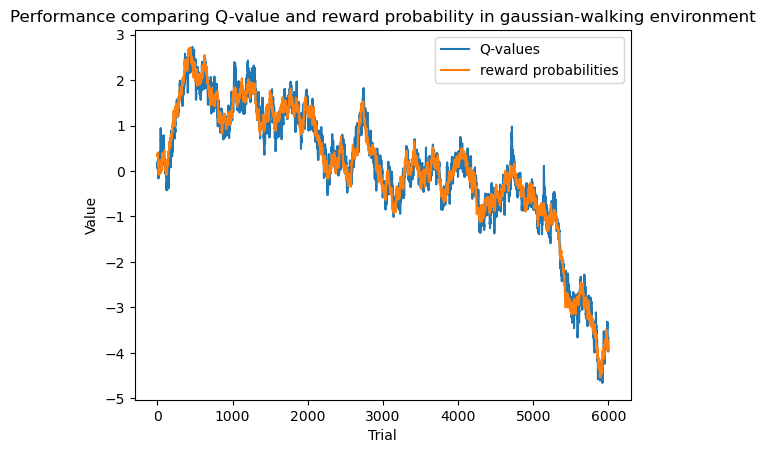

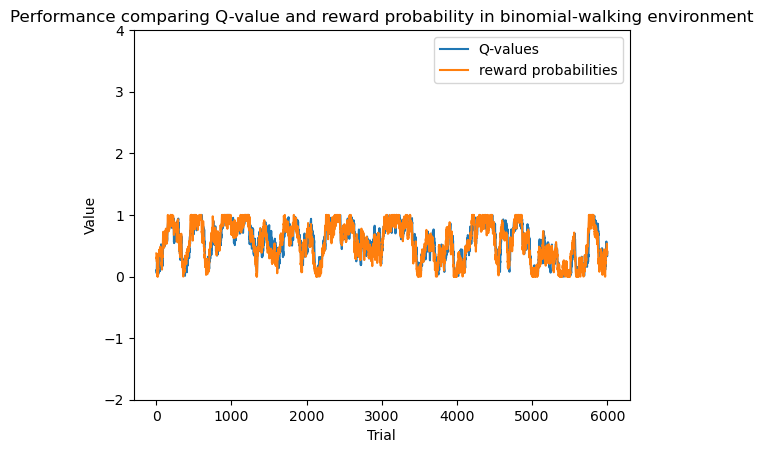

In [63]:

n_trials = 6000
np.random.seed(42)
random_starting_prob = np.random.rand()
q_values, reward_probs = run_experiment_compare([random_starting_prob], agent=gaussian_walking, beta=2, n_agents=1, n_trials=n_trials, learning_rate=0.1)
q_values_bi, reward_probs_bi = run_experiment_compare([random_starting_prob], agent=binominal_walking, beta=2, n_agents=1, n_trials=n_trials, learning_rate=0.1)
#print(np.mean(q_values, axis=1))
#print(reward_probs)

fig, ax = plt.subplots()  
ax.plot(range(n_trials), q_values[0], label="Q-values")  
ax.plot(range(n_trials), reward_probs[0], label="reward probabilities")
ax.set_title('Performance comparing Q-value and reward probability in gaussian-walking environment')
ax.set_xlabel('Trial')
ax.set_ylabel('Value')
ax.legend()

fig, ax = plt.subplots()  
ax.plot(range(n_trials), q_values_bi[0], label="Q-values")  
ax.plot(range(n_trials), reward_probs_bi[0], label="reward probabilities")
ax.set_title('Performance comparing Q-value and reward probability in binomial-walking environment')
ax.set_ylim(-2, 4)
ax.set_xlabel('Trial')
ax.set_ylabel('Value')
ax.legend()




In [64]:
def avg_corr(cor_coes):
    #calculate average coefficient 
    z_transformed = np.arctanh(cor_coes)
    z_mean = np.mean(z_transformed)
    average_coefficient = np.tanh(z_mean)
    return average_coefficient
    


C:\Users\Lena\AppData\Local\Temp\ipykernel_2576\3413872534.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noisy_means.append(noisy_means[-1]+float(np.random.normal(size=1, loc=0, scale=noise)))
C:\Users\Lena\AppData\Local\Temp\ipykernel_2576\3828766243.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)


Average Correlation Coefficient 0.9833979961092646


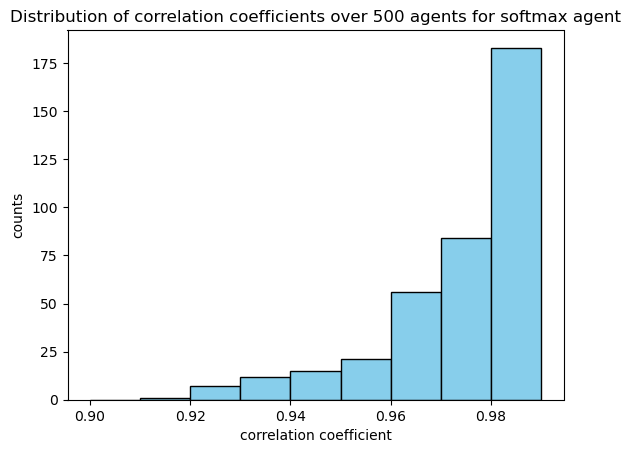

In [65]:
n_trials = 6000
np.random.seed(None)
q_values, reward_probs = run_experiment_compare([random_starting_prob], agent=gaussian_walking, beta=2, n_agents=500, n_trials=n_trials, learning_rate=0.1)
cor_coes = []
for i in range(len(q_values)):
    correlation_matrix = np.corrcoef(q_values[i], reward_probs[i])
    correlation_coefficient = correlation_matrix[0, 1]
    cor_coes.append(correlation_coefficient)


bins = np.arange(0.9, 1, 0.01)  
hist_counts, bin_edges = np.histogram(cor_coes, bins)

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(bin_edges[:-1], hist_counts, width=np.diff(bin_edges), color='skyblue', edgecolor='black', align='edge')
ax.set_title('Distribution of correlation coefficients over 500 agents for softmax agent')
ax.set_xlabel('correlation coefficient')
ax.set_ylabel('counts')

print("Average Correlation Coefficient", avg_corr(cor_coes))



C:\Users\Lena\AppData\Local\Temp\ipykernel_2576\3413872534.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noisy_means.append(noisy_means[-1]+float(np.random.normal(size=1, loc=0, scale=noise)))
C:\Users\Lena\AppData\Local\Temp\ipykernel_2576\3828766243.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)


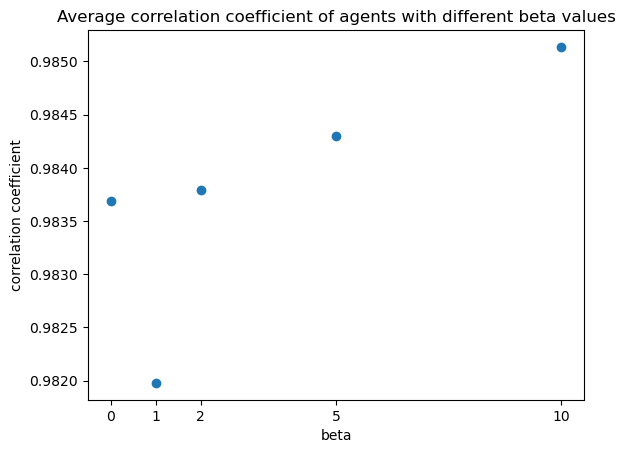

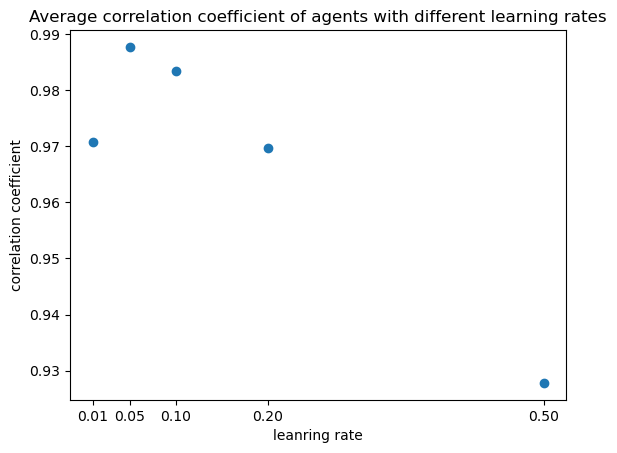

In [76]:

n_trials = 6000
all_avg_coef = []
betas = [0,1,2,5, 10]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5]
for b in betas:
    q_values, reward_probs = run_experiment_compare([random_starting_prob], agent=gaussian_walking, beta=b, n_agents=100, n_trials=n_trials, learning_rate=0.1)
    cor_coes = []
    for i in range(len(q_values)):
        correlation_matrix = np.corrcoef(q_values[i], reward_probs[i])
        correlation_coefficient = correlation_matrix[0, 1]
        cor_coes.append(correlation_coefficient)

    average_coefficient = avg_corr(cor_coes)
    all_avg_coef.append(average_coefficient)


fig, ax = plt.subplots()
ax.scatter(betas, all_avg_coef)
ax.set_title('Average correlation coefficient of agents with different beta values')
ax.set_ylabel('correlation coefficient')
ax.set_xlabel('beta')
ax.set_xticks(betas)

all_avg_coef = []
for a in learning_rate:
    q_values, reward_probs = run_experiment_compare([random_starting_prob], agent=gaussian_walking, beta=2, n_agents=50, n_trials=n_trials, learning_rate=a)
    cor_coes = []
    for i in range(len(q_values)):
        correlation_matrix = np.corrcoef(q_values[i], reward_probs[i])
        correlation_coefficient = correlation_matrix[0, 1]
        cor_coes.append(correlation_coefficient)

    average_coefficient = avg_corr(cor_coes)
    all_avg_coef.append(average_coefficient)


fig, ax = plt.subplots()
ax.scatter(learning_rate, all_avg_coef)
ax.set_title('Average correlation coefficient of agents with different learning rates')
ax.set_ylabel('correlation coefficient')
ax.set_xlabel('leanring rate')
ax.set_xticks(learning_rate)



C:\Users\Lena\AppData\Local\Temp\ipykernel_2576\3413872534.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noisy_means.append(noisy_means[-1]+float(np.random.normal(size=1, loc=0, scale=noise)))
C:\Users\Lena\AppData\Local\Temp\ipykernel_2576\3828766243.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action)


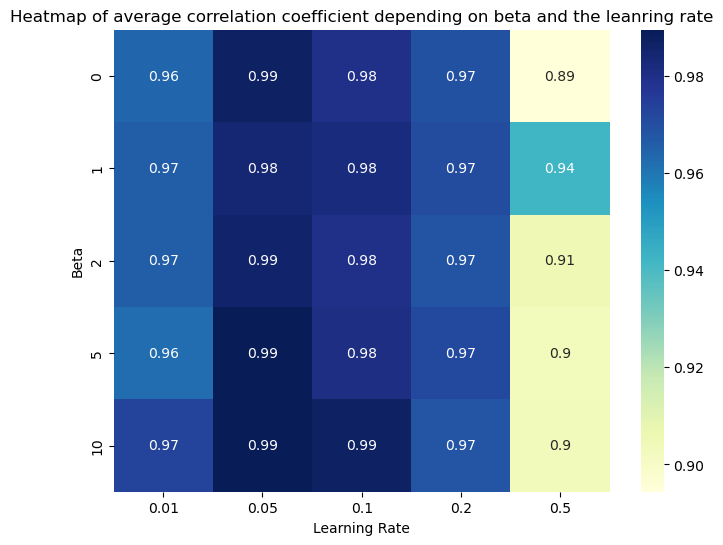

In [66]:
import seaborn as sns
betas = [0,1,2,5,10]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5]

# Create an empty array to store the function results
results = np.zeros((len(betas), len(learning_rate)))

# Evaluate the function for each combination of beta and learning_rate
for b, beta in enumerate(betas):
    for j, lr in enumerate(learning_rate):
        q_values, reward_probs = run_experiment_compare([random_starting_prob], agent=gaussian_walking, beta=beta, n_agents=20, n_trials=n_trials, learning_rate=lr)
        cor_coes = []
        for i in range(len(q_values)):
            correlation_matrix = np.corrcoef(q_values[i], reward_probs[i])
            correlation_coefficient = correlation_matrix[0, 1]
            cor_coes.append(correlation_coefficient)

        average_coefficient = avg_corr(cor_coes)
        results[b, j] = average_coefficient

# Plot a heatmap of the results
plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, xticklabels=learning_rate, yticklabels=betas, cmap='YlGnBu')
plt.title('Heatmap of average correlation coefficient depending on beta and the leanring rate')
plt.xlabel('Learning Rate')
plt.ylabel('Beta')
plt.show()

## additional material

For inspiration and more material on reinforcement learning and bandits, see

[link to model-free and model-based RL](https://github.com/ClaireSmid/Model-free_Model-based_Workshop)<br>


[link to recurrent neural networks and RL](https://github.com/kstach01/CogModelingRNNsTutorial)<br>

## Optional: The grid world problem

*Grid worlds* are simplified respresentations of the environment, that are often used for navigation simulation. As is implied by the name, grid worlds break down the environment into a grid, similar to a chess board. For the scope of this course we are going to stick with a very basic 4x4 gridworld.

Before we dive further into the code, a bit more background information on gridworlds. 

Gridworlds are so-called [Markov Decision Processes](https://en.wikipedia.org/wiki/Markov_decision_process). In contrast to the previous bandit task, gridworlds usually are multi-step problems, meaning that actions executed in one state cannot only result in reward, but also affect the upcoming state. This necessitates the agent to not only consider the immediate reward but also the expected cumulative reward. 

```
  ____    ____     ____   ____
  ____    ____     ____   ____

|| s00  |  s01  |  s02 | s03 ||
  ____    ____     ____   ____
    
|| s04  |  s05  |  s06 | s07 ||
  ____    ____     ____   ____
  
|| s08  |  s09  |  s10 | s11 ||
  ____    ____     ____   ____
   
|| s12  |  s13  |  s14 | s15 ||
  ____    ____     ____   ____
  ____    ____     ____   ____
```

Our agent always starts in the same start state (s_0, top left of board). From there, it will take *steps*, that gradually move him across the board. Movement is restricted to the cardinal directions (up, down, right, left). Reward is located in the terminal state (s_15, bottom right of board). Upon arrival at the site of reward, the agent receives the reward (associated with a positive value) and will be returned to the initial state, so the whole procedure can start again. The (time)steps between start and terminal state are regarded as a *run* (or *episode*). Start state, reward and terminal state do NOT change between runs. Thus, our gridworld environment is stable. Also, because each action transitions to a new state with 100% chance, the environment is also considered deterministic.

For this grid world example, we will implement the Q learning rule, which is defined as

$\LARGE Q_{new}(s,a) = Q_{old}(s,a) + \alpha * (R + \gamma max_{a} Q_{old}(s',a) - Q_{old}(s,a))$,

    where $\alpha$ is the learning rate,
    $\gamma$ is the discounting factor,
    and s' is the next state

Below, we define the most basic details for our gridworld.

In [67]:
nTrial = 50 #specify how many times you want to run the q-learning function
nAgent = 10

method = 'egreedy' #options: greedy | egreedy | softmax

alpha = 0.1 #learning rate
beta = 1 #inverse temperature
gamma = 1 # discounting factor
epsilon = 0.1 #parameter for ε-greedy action selection

actions = np.array(['up', 'left', 'down', 'right'])

s_0 = 0 #start state
s_terminal = 15 #final state (goal)

envsize = 4 #size of the environment (n x n)
iZ = 0
states= np.empty([envsize,envsize],dtype=float)
for iY in range(envsize):
    for iX in range(envsize):
        states[iY][iX] = iZ
        iZ +=1
#print('states')
#print(states)        

movecounter = np.empty([nTrial,nAgent] )

### Helper function

Some computational steps have to be performed multiple times.
Here we define those function so we can call them later on in the script.

In [68]:
# this is not an essential package, but it helps us to save variables for visualisation
from copy import deepcopy

In [69]:
def move1step(instate,action):
    
    coords = list(np.where(states == instate))
    
    if (action == 'up'):
        coords[0] -= 1
    if (action == 'down'):
        coords[0] += 1
    if (action == 'left'):
        coords[1] -= 1
    if (action == 'right'):
        coords[1] += 1
        
    if (coords[0] < 0):
        coords[0] = 0
    if (coords[1] < 0):
        coords[1] = 0 
    if (coords[0] >= envsize):
        coords[0] = envsize-1    
    if (coords[1] >= envsize):
        coords[1] = envsize-1
        
    outstate = states[coords[0],coords[1]]   
    return(outstate)  

def getReward(state1,state2):
    if (state2 == s_terminal):
        reward = 10 #final reward at the end of the run
    else:
        reward = 0 #intermediate reward (after each action) 
    if (state1 == state2):
        reward = 0 #reward for running into a wall?
    return reward    

Now that we have defined the most crucial parts for our grid world, we can put everything together.

For convenience, I have already added multiple agents, as this will allow us to draw more precise conclusions from the simulation data.

For the agent's parameters I have implemented very basic values. You can have a look how changing those parameters affects the performance in the grid world.

In [70]:
print('Agent')
for iA in range(nAgent):
    
    print(iA, end=' ')
    Q = np.zeros([len(actions),envsize,envsize] )

    #print('initial Q matrix:\n' + str(Q) + '\n')
    Q0 = deepcopy(Q)

    for iT in range(nTrial): # loop for the different runs
        #if (iT % 100) == 0:
            #print(iT)
        state = s_0
        moves = 0
        while (state != s_terminal): # loop within one run
        
            coord0 = np.where(states == state)

            qvals = Q[:,coord0[0],coord0[1]]
              
            # select action using choice rules
            if (method == 'softmax'):
                pvals = np.exp(beta*qvals)/np.sum(np.exp(beta*qvals))
                action = np.random.choice(actions,size = 1, p = pvals.flatten())            
            elif (method == 'greedy'):
                choices = np.array(qvals == np.max(qvals))
                action = np.random.choice(actions[choices.flatten()])            
            elif (method == 'egreedy'):
                if (np.random.random() < epsilon):
                    action = np.random.choice(actions, size = 1)
                else:
                    choices = np.array(qvals == np.max(qvals))
                    action = np.random.choice(actions[choices.flatten()])
            else:
                action = np.random.choice(actions)
        
            # interact with environment
            next_state = move1step(state,action)
            #print('next state: '+str(next_state))
            reward = getReward(state,next_state)
        
            actionidx = (action==actions)
            coord1 = np.where(states == next_state) 
        
            # update expectations using learing rules
            Q[actionidx,coord0[0],coord0[1]] = Q[actionidx,coord0[0],coord0[1]] + alpha * (reward + gamma * np.max(Q[:,coord1[0],coord1[1]]) - Q[actionidx,coord0[0],coord0[1]])
        
            if ((iT == 0) and (next_state == s_terminal)):
                #print('Q matrix before first successful run:\n' + str(Q) + '\n')
                Q1 = deepcopy(Q)
        
            # update variables
            state = next_state
            moves += 1
        
        #end of while loop
        movecounter[iT,iA] = moves
    #end of trial for loop
    #print('final Q matrix:\n' + str(Q) + '\n')
    Q2 = deepcopy(Q)
#end of agent for loop
#print('\n\nFinal Q(s,a) for agent '+str(iA))
#print(Q)

Agent
0 1 2 3 4 5 6 7 8 9 

In order to better understand the agents' behavior in the gridworld we can again make use of the `print()` and `plot()` function.

<div class="alert alert-warning" role="alert">
<h2> Questions </h2><br>
Before we continue, think about the performance of our agent. Do you have any hypothesis about this? What would you expect from a RL agent? How should his behavior change?
    
</div>

In the following sections we will try to answer those questions.

### Plotting performance

**Question:** What is our hypothesis for the performance of our agent?

**Answer:** Performance for learning agents should improve over time. Therefore we should expect to find improvements in performance for our grid world agent. Performance can be measured in multiple different ways. For our grid world example, we could define performance as is already plotted below: the number of steps it takes the agents to get from start state to terminal state. While the agent is aimlessly roaming the gridworld in the beginning, it quickly picks up the optimal path to the goal.

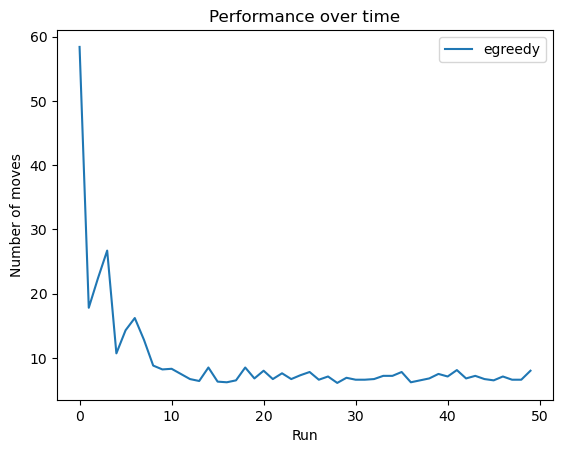

In [71]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.

xdata = range(nTrial)
ydata = np.mean(movecounter,axis=1)

ax.plot(xdata, ydata, label = method)  # Plot some data on the axes.

ax.set_title('Performance over time')
ax.set_xlabel('Run')
ax.set_ylabel('Number of moves')
ax.legend()

### Plotting values and policies

We can also visualize the state and action values of our gridworld. 

In [72]:
Qmat0 = np.max(Q0,axis=0)
Qmat1 = np.max(Q1,axis=0)
Qmat2 = np.max(Q2,axis=0)

print(Qmat0)
print(Qmat1)
print(Qmat2)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
[[2.88043107e+00 2.56374702e-02 2.80000000e-03 1.00000000e-02]
 [4.44281720e+00 6.35783209e+00 1.51210000e-01 1.14265000e+00]
 [4.81206664e-02 8.07886295e+00 1.41859837e+00 6.12579511e+00]
 [4.15370859e-01 9.34358099e+00 9.86697205e+00 0.00000000e+00]]


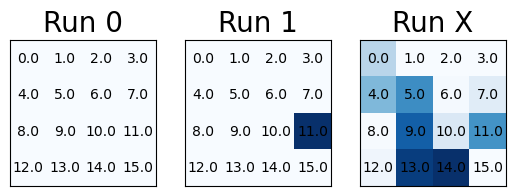

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

layout = [['s0', 's5/6'], ['s1', 's4'], ['s2', 's3']]

min_val, max_val = -1, 10

for i in range(envsize):
    for j in range(envsize):
        ax1.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
        ax2.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
        ax3.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
ax1.matshow(Qmat0, cmap=plt.cm.Blues)  
ax2.matshow(Qmat1, cmap=plt.cm.Blues)
ax3.matshow(Qmat2, cmap=plt.cm.Blues)

ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax3.axes.xaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)

ax1.title.set_text('Run 0')
ax1.title.set_size(20)
ax2.title.set_text('Run 1')
ax2.title.set_size(20)
ax3.title.set_text('Run X')
ax3.title.set_size(20)


<div class="alert alert-success" role="alert">
<h2> Ideas for individual assignments </h2><br>
The current grid world is perfectly deterministic. Actions reliably lead to the same outcome. Reward is always hidden in the same location. Recall that for our bandit example reward delivery was probabilistic. Can you implement some randomness in the grid world as well? Think about a few possible options. How could you implement those and what would be the consequences for agents' learning and decision-making?<br>
    
>Discuss your ideas with the workgroup teacher!
    
</div>

<div class="alert alert-success" role="alert">
<h2> Ideas for individual assignments </h2><br>
So far, we have only implemented different decision rules at this point. But we could also think about different learning rules. As discussed in the lecture, a prominent example from Sutton & Barto (2018, p.132) is the cliff world. In their variant of the grid world, learning for the different learning rules translates into very distinct behavioral patterns. It nicely illustrates how small changes in the algorithm can have quite strong effects on decision making. Have a look at the example. Can you construct a cliff world and replicate the findings reported by Sutton & Barto? <br> 
    
>Discuss your ideas with the workgroup teacher!
</div>